In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import sys
import os


# Set random seed for reproducibility
np.random.seed(1)
torch.manual_seed(1)

# Generate data
n_samples = 20000
y = np.random.uniform(0, 1, n_samples)
X = y.reshape(-1, 1)
xtrue = np.zeros_like(y)
xtrue[y < 0.5] = np.random.normal(0, 1, np.sum(y < 0.5))
x = xtrue + np.random.normal(0, 1, n_samples)
s = np.ones_like(x)
Z = np.ones((n_samples, 1))

 

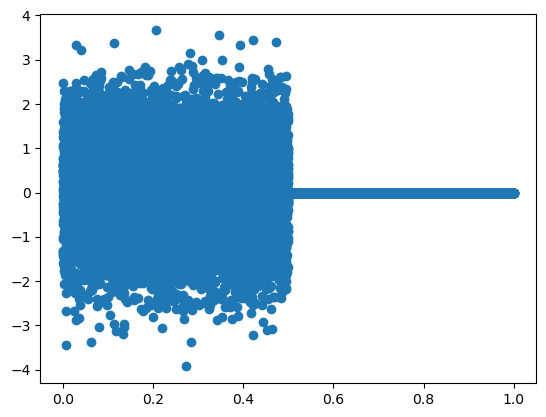

In [35]:
plt.scatter(y, xtrue) 

In [36]:
# Assuming we have the comoR functions implemented in Python
# For now, we'll create dummy data for fit_como.data_loglik
num_classes = 20

sys.path.append(r"c:\Document\Serieux\Travail\python_work\cEBNM_torch\py")
# Import utils.py directly
from utils import *
from numerical_routine import *
from distribution_operation import *
from posterior_computation import *
 
scale = autoselect_scales_mix_norm(betahat=x,
                                   sebetahat=np.full(x.shape[0],1),
                                        max_class=num_classes ) 

num_classes= scale.shape[0]
print( (scale) )

[ 0.          0.53479093  1.06958186  1.6043728   2.13916373  2.67395466
  3.20874559  3.74353652  4.27832746  4.81311839  5.34790932  5.88270025
  6.41749118  6.95228212  7.48707305  8.02186398  8.55665491  9.09144585
  9.62623678 10.16102771]


Epoch [10/40], Loss: 637.2554
Epoch [20/40], Loss: 636.9205
Epoch [30/40], Loss: 636.8301
Epoch [40/40], Loss: 636.6774


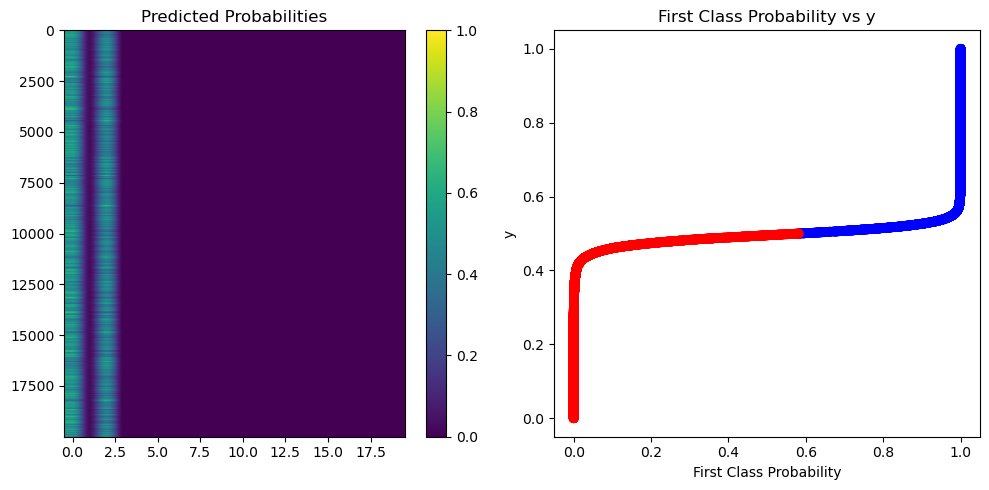

In [37]:


fit_como_data_loglik = get_data_loglik_normal(betahat=x,
                                              sebetahat=np.full(x.shape[0],1),
                                              location=0,
                                              scale=scale)

 
# Convert data to PyTorch tensors
x_train = torch.FloatTensor(y).reshape(-1, 1) 
y_train = torch.FloatTensor(fit_como_data_loglik)

# Define the model
class SimpleNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, num_classes)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.softmax(self.fc4(x))
        return x

# Custom loss function
def custom_loss(y_pred, y_true):
    return -torch.sum(torch.log(torch.sum(torch.exp(y_true) * y_pred, dim=1)))

# Initialize model
model = SimpleNet(1, 64, num_classes)

# Define optimizer
optimizer = optim.Adam(model.parameters())

# Training loop
num_epochs = 40
batch_size = 400

for epoch in range(num_epochs):
    for i in range(0, len(x_train), batch_size):
        batch_x = x_train[i:i+batch_size]
        batch_y = y_train[i:i+batch_size]
        
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = custom_loss(outputs, batch_y)
        loss.backward()
        optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Predict
model.eval()
with torch.no_grad():
    tt1 = model(x_train).numpy()

# Plotting
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(tt1, aspect='auto')
plt.title('Predicted Probabilities')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.scatter(tt1[:, 0], y, c=['red' if yi < 0.5 else 'blue' for yi in y])
plt.title('First Class Probability vs y')
plt.xlabel('First Class Probability')
plt.ylabel('y')

plt.tight_layout()
plt.show()
 

Text(0, 0.5, 'y')

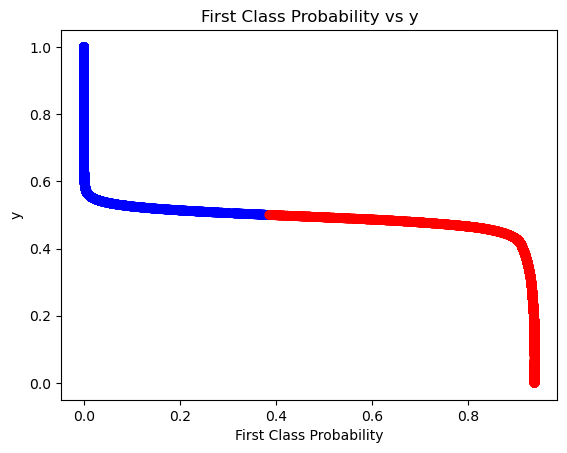

In [38]:
plt.scatter(tt1[:, 2], y, c=['red' if yi < 0.5 else 'blue' for yi in y])
plt.title('First Class Probability vs y')
plt.xlabel('First Class Probability')
plt.ylabel('y')

In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from posterior_computation import posterior_mean_norm  # Ensure this import works

# [Previous code for data generation and model definition remains the same]

# After training the model, compute the posterior mean
model.eval()
with torch.no_grad():
    all_pi_values = model(x_train)

all_pi_values_np = all_pi_values.numpy()
y_n_np = x  # This is our noisy observation
print(s)

[1. 1. 1. ... 1. 1. 1.]


C:\Users\willi\AppData\Local\Temp\ipykernel_31268\875036270.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  est_post[i] = posterior_mean_norm(


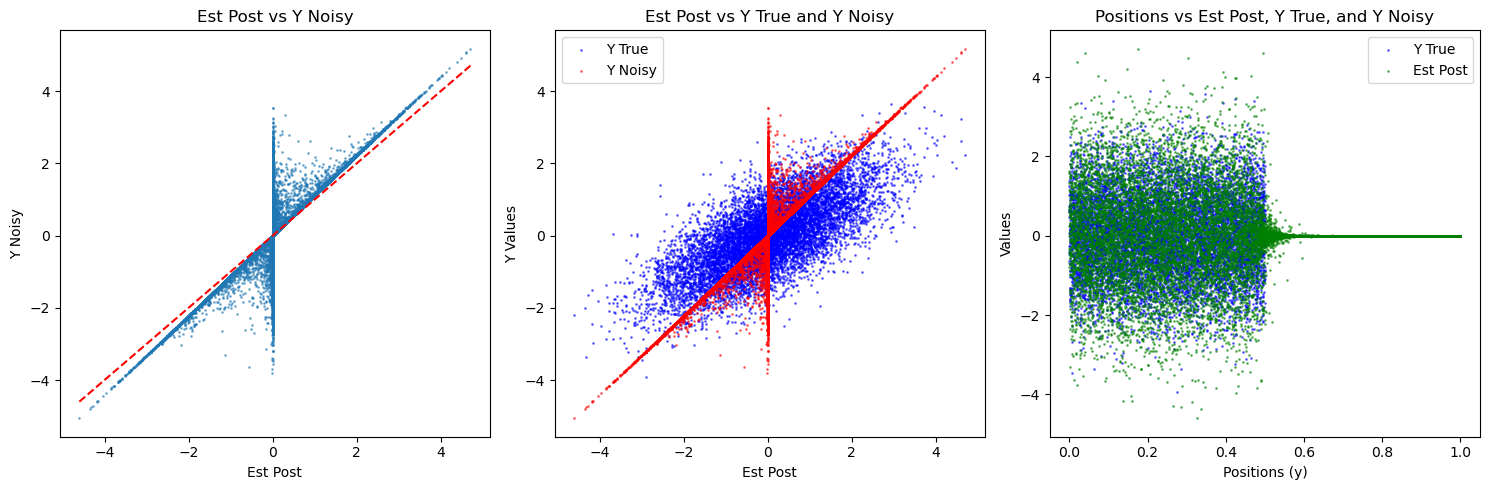


Statistics:
Est Post - Mean: 0.0034, Std: 0.8846
Y Noisy - Mean: 0.0033, Std: 1.2246
Y True - Mean: -0.0011, Std: 0.7022

Mean Squared Error:
MSE (Est Post vs Y Noisy): 0.5074
MSE (Est Post vs Y True): 0.4002


In [40]:

# Compute posterior mean
est_post = np.zeros(n_samples)
for i in range(n_samples):
    est_post[i] = posterior_mean_norm(
        betahat=np.array([y_n_np[i]]),
        sebetahat=np.array([s[i]]),
        log_pi=np.log(all_pi_values_np[i, :]),
        scale= scale   # Assuming this is available from earlier in your code
    ).post_mean

# Plot results
plt.figure(figsize=(15, 5))

# Plot 1: Est Post vs Y Noisy
plt.subplot(1, 3, 1)
plt.scatter(est_post, y_n_np, alpha=0.5, s=1)
plt.title('Est Post vs Y Noisy')
plt.xlabel('Est Post')
plt.ylabel('Y Noisy')
plt.plot([min(est_post), max(est_post)], [min(est_post), max(est_post)], 'r--')

# Plot 2: Est Post vs Y True
plt.subplot(1, 3, 2)
plt.scatter(est_post, xtrue, alpha=0.5, s=1, label='Y True', color='blue')
plt.scatter(est_post, y_n_np, alpha=0.5, s=1, label='Y Noisy', color='red')
plt.title('Est Post vs Y True and Y Noisy')
plt.xlabel('Est Post')
plt.ylabel('Y Values')
plt.legend()

# Plot 3: Positions vs Est Post, Y True, and Y Noisy
plt.subplot(1, 3, 3)
#plt.scatter(y, y_n_np, alpha=0.5, s=1, label='Y Noisy', color='red')
plt.scatter(y, xtrue, alpha=0.5, s=1, label='Y True', color='blue')
plt.scatter(y, est_post, alpha=0.5, s=1, label='Est Post', color='green')
plt.title('Positions vs Est Post, Y True, and Y Noisy')
plt.xlabel('Positions (y)')
plt.ylabel('Values')
plt.legend()

plt.tight_layout()
plt.show()

# Print some statistics
print("\nStatistics:")
print(f"Est Post - Mean: {np.mean(est_post):.4f}, Std: {np.std(est_post):.4f}")
print(f"Y Noisy - Mean: {np.mean(y_n_np):.4f}, Std: {np.std(y_n_np):.4f}")
print(f"Y True - Mean: {np.mean(xtrue):.4f}, Std: {np.std(xtrue):.4f}")

# Calculate and print MSE
mse_noisy = np.mean((est_post - y_n_np)**2)
mse_true = np.mean((est_post - xtrue)**2)
print(f"\nMean Squared Error:")
print(f"MSE (Est Post vs Y Noisy): {mse_noisy:.4f}")
print(f"MSE (Est Post vs Y True): {mse_true:.4f}")
